# <u>G18 Facial Expression Recognition System


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# load the required modules
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import cv2
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.layers import MaxPool2D
%matplotlib inline

/bin/bash: pip install tensorflow==2.8: command not found
/bin/bash: apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2: command not found


# <u>Data Preparation
The training set consists of 92,968 examples.
<br>The test set consists of 17,356 examples. 
<br>The cross validation set consists of another 17,356 examples.
There is a csv file containing the emotion values for all the data.

In [3]:
# load the images
images_train = np.load('/content/drive/My Drive/rfea/train_raw.npy')

In [4]:
# load the cross validation images
images_cv = np.load('/content/drive/My Drive/rfea/cv_raw.npy')
# load the test images
images_test = np.load('/content/drive/My Drive/rfea/test_raw.npy')

In [5]:
# load the corresponding emotion values
y_train = pd.read_csv('/content/drive/My Drive/rfea/y_train.csv', header=None)
y_val = pd.read_csv('/content/drive/My Drive/rfea/y_val.csv', header=None)
y_test = pd.read_csv('/content/drive/My Drive/rfea/y_test.csv', header=None)

In [6]:
print(len(images_train))
print(len(images_cv))
print(len(images_test))
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

92968
17356
17356
(92968, 1)
(17356, 1)
(17356, 1)


### Data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76a5198490>]],
      dtype=object)

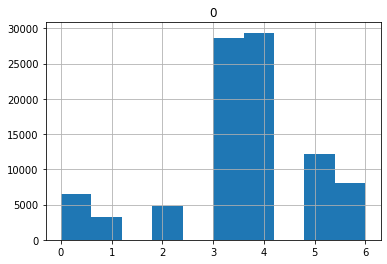

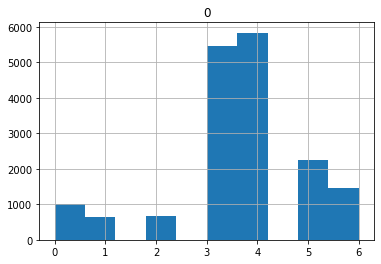

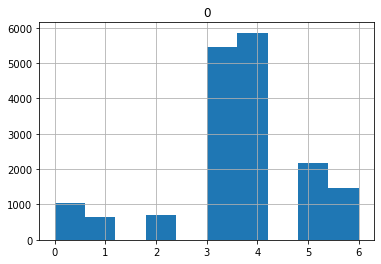

In [ ]:
# data distribution
y_train.hist()
y_val.hist()
y_test.hist()

In [ ]:
# distribution of pictures
y_train.value_counts()
y_val.value_counts()
y_test.value_counts()

4    5858
3    5459
5    2177
6    1475
0    1041
2     691
1     655
dtype: int64

### Prepare output labels

In [7]:
# create one hot encoding
y_train_ohe = to_categorical(y_train, num_classes=7)
y_val_ohe = to_categorical(y_val, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train_ohe.shape)
print(y_val_ohe.shape)
print(y_test_ohe.shape)

(92968, 7)
(17356, 7)
(17356, 7)


### Sanity checking 

In [ ]:
# for displaying an image from dataset
def show(img):
    # resize the image
    show_image = img.reshape(48,48)
    # show the image
    plt.imshow(show_image, cmap='gray')

Emotion:0        0
1        0
2        0
3        0
4        0
        ..
92963    6
92964    6
92965    6
92966    6
92967    6
Name: 0, Length: 92968, dtype: int64


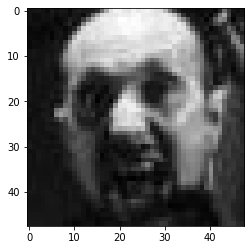

In [ ]:
# verify the image with its label
index = 0
# training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:0        0
1        0
2        0
3        0
4        0
        ..
17351    6
17352    6
17353    6
17354    6
17355    6
Name: 0, Length: 17356, dtype: int64


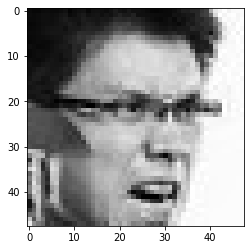

In [ ]:
# cv image
show(images_cv[index])
print('Emotion:' + str(y_val[index]))

Emotion:0        0
1        0
2        0
3        0
4        0
        ..
17351    6
17352    6
17353    6
17354    6
17355    6
Name: 0, Length: 17356, dtype: int64


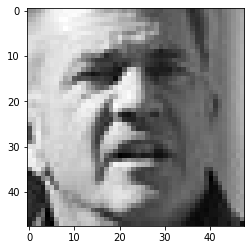

In [ ]:
# test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

# <u>Preprocessing

In [8]:
# reshape the images for keras model
images_train = np.expand_dims(images_train, 3)
images_val = np.expand_dims(images_cv, 3)
images_test = np.expand_dims(images_test, 3)

In [9]:
print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(92968, 48, 48, 1)
(17356, 48, 48, 1)
(17356, 48, 48, 1)


### Make the model

In [45]:
model = Sequential()

# 1st stage
model.add(Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, 3, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(32, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 2nd stage
model.add(Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(96, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(96, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 3rd stage
model.add(Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))

# FC layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_44 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_45 (Bat  (None, 24, 24, 32)      

In [47]:
# compile the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# <u>Model Architecture

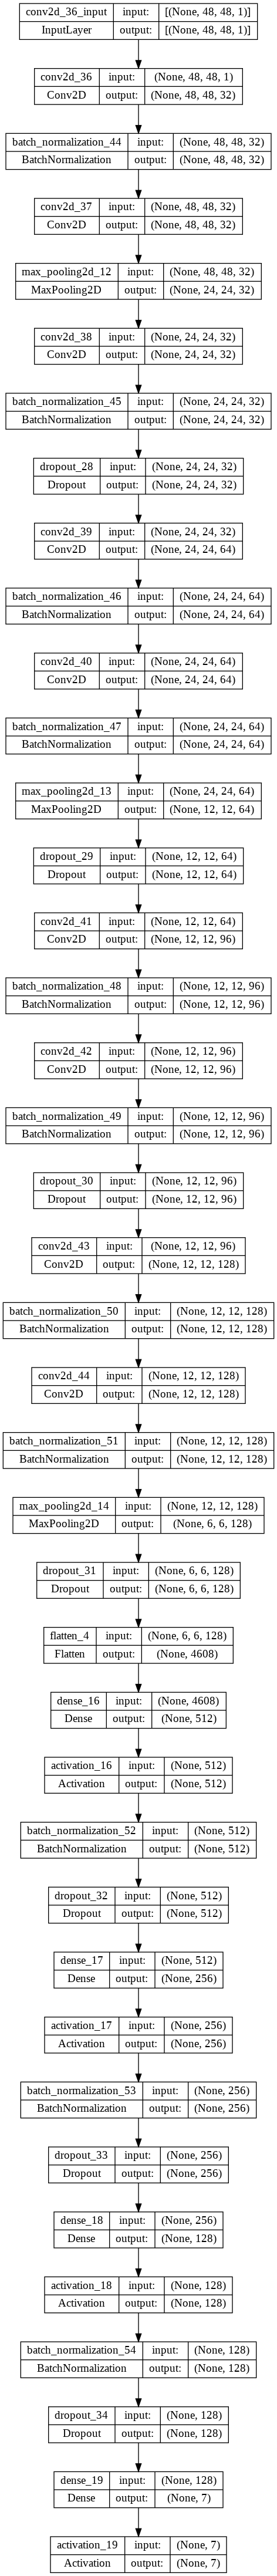

In [48]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True)

In [49]:
# save the model weights after each epoch if the validation loss decreases
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/rfea/data/weights_best.hdf5', verbose=1, save_best_only=True)

In [50]:
# load already saved model if needed
if os.path.exists('/content/drive/My Drive/rfea/data/model.h5'):
    model = load_model('/content/drive/My Drive/rfea/data/model.h5')
else:
    print('No model to load !')

No model to load !


### NOTE: The model was trained for 50 epochs but was done not in one go, so in the fit function there is only 5 written as it was the last time the model was run

In [51]:
# start training the model
hist = model.fit(images_train, y_train_ohe, batch_size=512, epochs=50, verbose=1,
          validation_data=(images_val, y_val_ohe), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
model.save_weights('/content/drive/My Drive/rfea/data/weights.h5')
model.save('/content/drive/My Drive/rfea/data/model.h5')

Epoch 1/50
182/182 [==============================] - ETA: 0s - loss: 2.0390 - accuracy: 0.2902
Epoch 1: val_loss improved from inf to 1.61886, saving model to /content/drive/My Drive/rfea/data/weights_best.hdf5
182/182 [==============================] - 29s 149ms/step - loss: 2.0390 - accuracy: 0.2902 - val_loss: 1.6189 - val_accuracy: 0.3328
Epoch 2/50
182/182 [==============================] - ETA: 0s - loss: 1.6038 - accuracy: 0.4315
Epoch 2: val_loss improved from 1.61886 to 1.56626, saving model to /content/drive/My Drive/rfea/data/weights_best.hdf5
182/182 [==============================] - 28s 155ms/step - loss: 1.6038 - accuracy: 0.4315 - val_loss: 1.5663 - val_accuracy: 0.4046
Epoch 3/50
182/182 [==============================] - ETA: 0s - loss: 1.4238 - accuracy: 0.5144
Epoch 3: val_loss improved from 1.56626 to 1.49619, saving model to /content/drive/My Drive/rfea/data/weights_best.hdf5
182/182 [==============================] - 28s 153ms/step - loss: 1.4238 - accuracy: 0.5

## <u>Model Evaluation
The model achieves 61.5% accuracy on the unseen test set.

In [52]:
# training loss and accuracy
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(images_test, y_test_ohe,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.746267557144165
Validation Accuracy:  0.5833141207695007
543/543 [==============================] - 3s 6ms/step - loss: 1.1695 - accuracy: 0.6148
Test score: 1.1694661378860474
Test accuracy: 0.6147729754447937


### Plot the training loss and accuracy graph

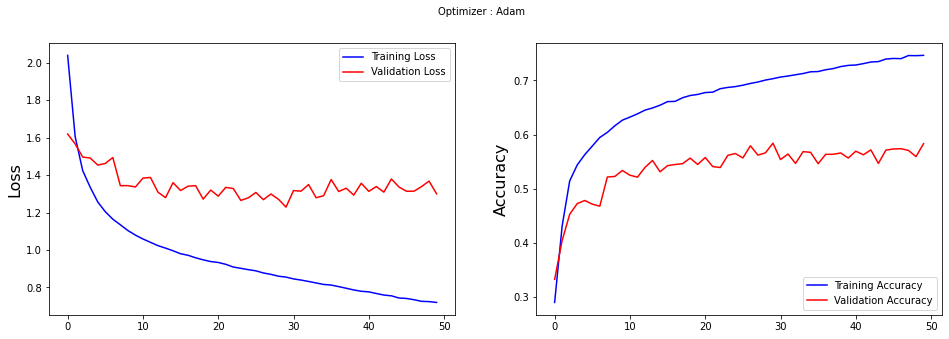

In [53]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()



## Let us do prediction on some faces

In [ ]:
# read image 
images = []
for filename in os.listdir('test_images\\'):
    path = os.path.join('test_images\\', filename)
    images.append(cv2.imread(path, -1))    

In [ ]:
# do prediction for the images
predictions = []
for img in images:
    # change to greyscale
    curr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    curr_img = cv2.resize(curr_img, (48,48))
    curr_img = np.reshape(curr_img, (1, 48, 48, 1))
    predictions.append(np.argmax(model.predict(curr_img)))

In [ ]:
# list of given emotions
EMOTIONS = ['Angry', 'Disgusted', 'Fearful',
            'Happy', 'Sad', 'Surprised', 'Neutral']

In [ ]:
# bgr to rgb
for i in range(5):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

Predicted Emotion: Happy


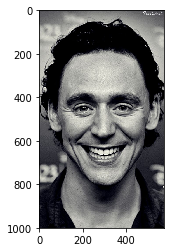

In [ ]:
plt.imshow(images[0])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[0]]))

Predicted Emotion: Sad


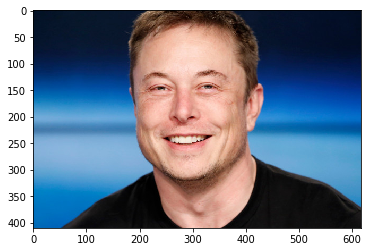

In [ ]:
plt.imshow(images[1])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[1]]))

Predicted Emotion: Sad


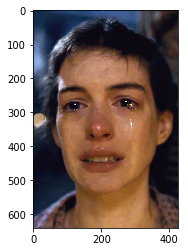

In [ ]:
plt.imshow(images[2])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[2]]))

Predicted Emotion: Angry


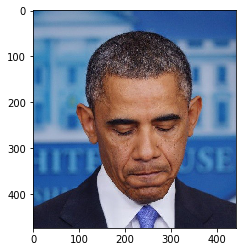

In [ ]:
plt.imshow(images[3])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[3]]))

Predicted Emotion: Surprised


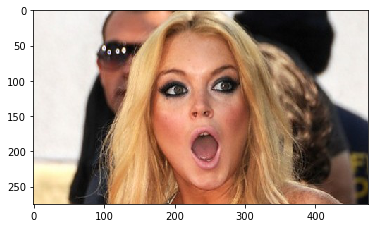

In [ ]:
plt.imshow(images[4])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[4]]))